In [ ]:
pip install seawater

In [41]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata  # Importo griddata
import cmocean #colori per oceanografia
import gsw
import seawater as sw
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
from scipy.spatial import cKDTree


#definition of the file path
file_path = "C:/Users/Marta/Desktop/PS118_phys_oce1.tab"

#load the data 
df4 = pd.read_csv(file_path, skiprows=51272, nrows=23576, sep='\t')
#data contains the oceanographic data in table form 

#rename the columns
df4.columns = ['Event', 'Date/Time', 'Latitude', 'Longitude', 'Elevation_m', 
               'Depth_m', 'Pressure_dbar',
               'Temperature_C', 'Conductivity_mS_cm', 'Salinity', 'Tpot_C', 
               'Sigma_theta', 'O2', 'O2_sat', 'Attenuation', 'Fluorometer', 'NOBS']

#columns_to_drop contains the names of the last 3 columns i want to remove
columns_to_drop = df4.columns[-3:]

data = df4.drop(columns=columns_to_drop)
#data is updated. Last 3 columns ahve been excluded

#convert the "Date/Time" column to datetime format
data['Date/Time'] = pd.to_datetime(data['Date/Time'])

#create separate "Date" and "Time" columns
data['Date'] = data['Date/Time'].dt.date
data['Time'] = data['Date/Time'].dt.time

#drop the original "Date/Time" column if not needed
data = data.drop(columns=['Date/Time'])

#reorder columns to place 'Date' and 'Time' after 'Event'
data = data[['Event', 'Date', 'Time', 'Latitude', 'Longitude', 'Elevation_m', 
             'Depth_m', 'Pressure_dbar', 'Temperature_C', 'Conductivity_mS_cm', 
             'Salinity', 'Tpot_C', 'Sigma_theta', 'O2', 'O2_sat']]

#meridional averaging
data_mer_av = data.groupby(['Pressure_dbar', 'Longitude'])[['Tpot_C', 'Salinity', 'Latitude', 'Sigma_theta']].mean().reset_index()

#extract variables
long = data_mer_av['Longitude'].values
lat = data_mer_av['Latitude'].values
p = data_mer_av['Pressure_dbar'].values
Tpot = data_mer_av['Tpot_C'].values
Salinity = data_mer_av['Salinity'].values
sigma_theta = data_mer_av['Sigma_theta'].values  

#TEOS10
SA = gsw.conversions.SA_from_SP(Salinity, p=p, lon=long, lat=lat) #absolute S
CT = gsw.conversions.CT_from_pt(SA, Tpot) #conservative T
sigma_theta_gsw0 = gsw.sigma0(SA, CT)
sigma_theta_gsw1 = gsw.sigma1(SA, CT)
sigma_theta_gsw2 = gsw.sigma2(SA, CT)

#structured grid
long_grid = np.linspace(long.min(), long.max(), 13)  # 13 longitude points
p_grid = np.linspace(p.min(), p.max(), 2500)  # 2500 pressure levels
long_grid, p_grid = np.meshgrid(long_grid, p_grid)

#interpolation in grid
grid_Tpot = griddata((long, p), Tpot, (long_grid, p_grid), method='linear')
grid_Salinity = griddata((long, p), Salinity, (long_grid, p_grid), method='linear')
grid_sigma_theta = griddata((long, p), sigma_theta, (long_grid, p_grid), method='linear')
grid_sigma_theta_gsw0 = griddata((lon, p), sigma_theta_gsw0, (long_grid, p_grid), method='linear')
grid_sigma_theta_gsw1 = griddata((lon, p), sigma_theta_gsw1, (long_grid, p_grid), method='linear')
grid_sigma_theta_gsw2 = griddata((lon, p), sigma_theta_gsw2, (long_grid, p_grid), method='linear')

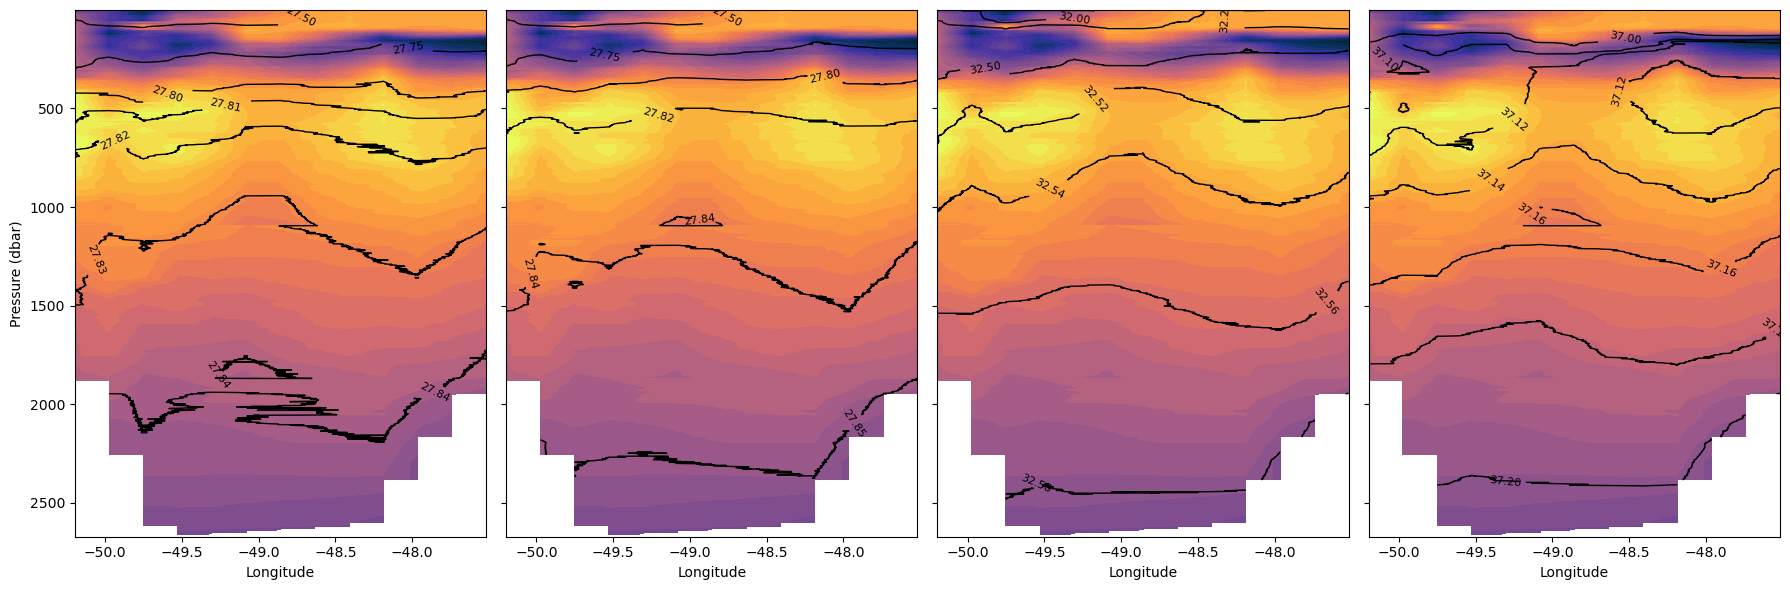

In [85]:
#plots
fig, (ax, ax0, ax1, ax2) = plt.subplots(1, 4, figsize=(18, 6), sharey=True)

#in situ data (=EOS80)
#EOS80: sigma_theta_sw=sw.dens0(Salinity,Tpot)-1000
cntr = ax.contourf(long_grid, p_grid, grid_Tpot, levels=30, cmap='cmo.thermal', vmin=-1.2, vmax=0.5)

#density isolines
sigma_theta_bounds = [27.5, 27.75, 27.80, 27.81, 27.82, 27.83, 27.84]
intervals =len(sigma_theta_bounds)-1
contours = ax.contour(long_grid, p_grid, grid_sigma_theta, levels=sigma_theta_bounds, colors='black', linewidths=1)
ax.clabel(contours, inline=True, fmt='%0.2f', fontsize=8)
ax.set_xlabel('Longitude')
ax.set_ylabel('Pressure (dbar)')


#sigma0
cntr_gsw0 = ax0.contourf(long_grid, p_grid, grid_Tpot, levels=30, cmap='cmo.thermal', vmin=-1.2, vmax=0.5)

#density isolines
sigma_theta_bounds_gsw0 = [27.5, 27.75, 27.80, 27.82, 27.84, 27.85]
intervals_gsw0 =len(sigma_theta_bounds_gsw0)-1
contours_gsw0 = ax0.contour(long_grid, p_grid, grid_sigma_theta_gsw0, levels=sigma_theta_bounds_gsw0, colors='black', linewidths=1)
ax0.clabel(contours_gsw0, inline=True, fmt='%0.2f', fontsize=8)
ax0.set_xlabel('Longitude')


#sigma1
cntr_gsw1 = ax1.contourf(long_grid, p_grid, grid_Tpot, levels=30, cmap='cmo.thermal', vmin=-1.2, vmax=0.5)

#density isolines
sigma_theta_bounds_gsw1 = [32.0, 32.25, 32.5, 32.52, 32.54, 32.56, 32.58]
intervals_gsw1 =len(sigma_theta_bounds_gsw1)-1
contours_gsw1 = ax1.contour(long_grid, p_grid, grid_sigma_theta_gsw1, levels=sigma_theta_bounds_gsw1, colors='black', linewidths=1)
ax1.clabel(contours_gsw1, inline=True, fmt='%0.2f', fontsize=8)
ax1.set_xlabel('Longitude')


#sigma2
cntr_gsw2 = ax2.contourf(long_grid, p_grid, grid_Tpot, levels=30, cmap='cmo.thermal', vmin=-1.2, vmax=0.5)

#density isolines
sigma_theta_bounds_gsw2 = [36.4, 37.0, 37.1, 37.12, 37.14, 37.16, 37.18, 37.2]
intervals_gsw2 =len(sigma_theta_bounds_gsw2)-1
contours_gsw2 = ax2.contour(long_grid, p_grid, grid_sigma_theta_gsw2, levels=sigma_theta_bounds_gsw2, colors='black', linewidths=1)
ax2.clabel(contours_gsw2, inline=True, fmt='%0.2f', fontsize=8)
ax2.set_xlabel('Longitude')

ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [103]:
#sigma_theta_sw=sw.dens0(Salinity,Tpot)-1000
#sigma_theta_bounds_sw = [27.5, 27.75, 27.80, 27.81, 27.82, 27.83, 27.84]
#plt.contour(long_grid, p_grid, grid_sigma_theta, levels=sigma_theta_bounds, colors='red', linewidths=1)
#plt.contour(long_grid, p_grid, grid_sigma_theta_sw, levels=sigma_theta_bounds_sw, colors='yellow', linewidths=1)
#plt.contour(long_grid, p_grid, grid_sigma_theta_gsw0, levels=sigma_theta_bounds_gsw0, colors='black', linewidths=1)